# Import Libraries and constants

In [1]:
!pip install numba=="0.57.1"
!pip install tsfresh
import json
import yfinance as yf
import datetime
import numpy as np
import xgboost as xgb
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from matplotlib import pyplot as plt
from pandas import DataFrame
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

END_DATE = datetime.datetime.now()
START_DATE = END_DATE - datetime.timedelta(days=5 * 365)
ESG_QUERY = 'https://query2.finance.yahoo.com/v1/finance/esgChart?symbol='
SYMBOLS = ['AMZN', 'AAPL', 'XOM', 'NKE', 'PFE', 'TSLA']

# Function to get Price Data and ESG Scores for a company

In [2]:
def get_data(_symbol: str):
    price_data: DataFrame = yf.download(_symbol, start=START_DATE, end=END_DATE)['Close']
    esg_data = json.loads(open(f'/esgChart{_symbol}.json', 'r').read())['esgChart']['result'][0]

    symbol_series = esg_data['symbolSeries']
    matrix = []
    indices = []

    for i in range(len(symbol_series['timestamp'])):
        timestamp = datetime.datetime.fromtimestamp(symbol_series['timestamp'][i]).date()
        esgScore = symbol_series['esgScore'][i]
        governanceScore = symbol_series['governanceScore'][i]
        environmentScore = symbol_series['environmentScore'][i]
        socialScore = symbol_series['socialScore'][i]
        try:
            next_month = timestamp.replace(month=timestamp.month + 1)
        except ValueError:
            next_month = timestamp.replace(month=1)
        last_day_of_month = next_month - datetime.timedelta(days=1)

        while timestamp <= last_day_of_month:
            indices.append(timestamp)
            matrix.append((esgScore, governanceScore, environmentScore, socialScore))
            timestamp += datetime.timedelta(days=1)

    esg_df = DataFrame(matrix, columns=['ESG ' + _symbol, 'Governance Score ' + _symbol, 'Environment Score ' + _symbol, 'Social Score ' + _symbol], index=indices)

    combined_df = esg_df.join(price_data, how='outer').rename(columns={'Close': 'Close ' + _symbol})

    # Forward Fill Null Values
    combined_df.fillna(method='ffill', inplace=True)
    combined_df.dropna(inplace=True)

    return combined_df

# Function to create features using tsfresh

In [3]:
def create_features(dataframe: DataFrame):
    new_df = dataframe.copy()
    new_df.index = pd.to_datetime(df.index)
    new_df['year'] = new_df.index.year
    new_df['quarter'] = dataframe.index.quarter
    new_df['month'] = dataframe.index.month

    return new_df

# Get all data combined in one DataFrame

In [4]:
df = DataFrame()
for symbol in SYMBOLS:
    data = get_data(symbol)
    df = df.join(data, how='outer')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


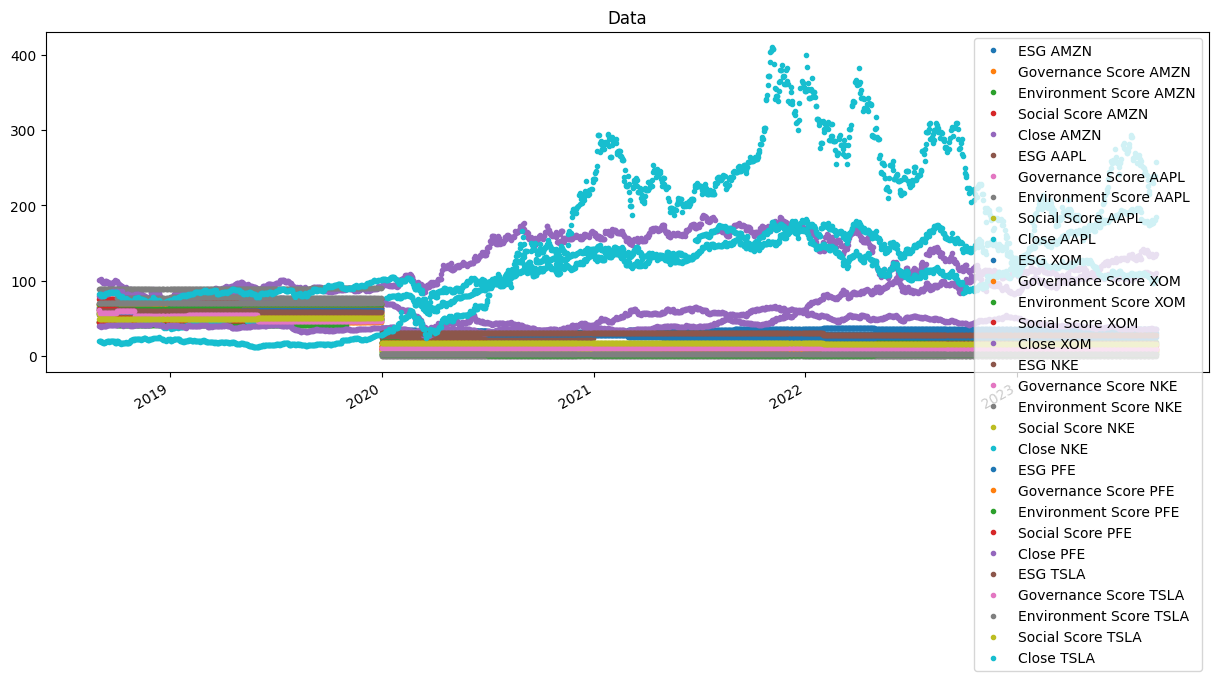

[0]	validation_0-rmse:19.83461	validation_1-rmse:20.27179
[1]	validation_0-rmse:13.92590	validation_1-rmse:14.26875
[2]	validation_0-rmse:9.78287	validation_1-rmse:10.02732
[3]	validation_0-rmse:6.87453	validation_1-rmse:7.05051
[4]	validation_0-rmse:4.83199	validation_1-rmse:4.95899
[5]	validation_0-rmse:3.39890	validation_1-rmse:3.48818
[6]	validation_0-rmse:2.38982	validation_1-rmse:2.45291
[7]	validation_0-rmse:1.68048	validation_1-rmse:1.72696
[8]	validation_0-rmse:1.18259	validation_1-rmse:1.21511
[9]	validation_0-rmse:0.83213	validation_1-rmse:0.85559
[10]	validation_0-rmse:0.58603	validation_1-rmse:0.60120
[11]	validation_0-rmse:0.41312	validation_1-rmse:0.42320
[12]	validation_0-rmse:0.29205	validation_1-rmse:0.29737
[13]	validation_0-rmse:0.20709	validation_1-rmse:0.20832
[14]	validation_0-rmse:0.14800	validation_1-rmse:0.14616
[15]	validation_0-rmse:0.10651	validation_1-rmse:0.10286
[16]	validation_0-rmse:0.07735	validation_1-rmse:0.07247
[17]	validation_0-rmse:0.05678	valid

In [11]:
# df = create_features(df)
df.plot(style='.', figsize=(15, 5), title='Data')
plt.show()

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-4]], df[df.columns[-4]], random_state=0, test_size=0.2)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

reg: XGBRegressor = xgb.XGBRegressor(n_estimators=100, early_stopping_rounds=50)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
y_pred = reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(reg.score(X_train, y_train))